# **Exploratory Data Analysis**

In this notebook, we perform an initial exploration of a particle-physics–inspired
event classification dataset. The goal is to understand the structure of the data,
the balance between signal and background events, and the physical meaning of the
available features before applying any machine learning models.

This step is essential to ensure that subsequent modeling choices are informed by
both statistical properties and physical intuition.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scienceplots
plt.style.use(['science','notebook', 'grid'])

In [2]:
data = pd.read_csv(
    "../Data - Events/Particle-Physics-Event-Classification.csv"
)

### **Dataset Overview**

We begin by inspecting the size of the dataset, the available features,
and the target labels to obtain a high-level understanding of the data.

In [3]:
print(data.shape)
print(data.columns)

(250000, 33)
Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')


In [4]:
data.head()


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,9.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


Several features contain placeholder values (e.g. -999), indicating missing or undefined physical quantities. These will be handled explicitly during preprocessing in subsequent notebooks.

In [5]:
missing_fraction = (data == -999).mean().sort_values(ascending=False)
missing_fraction.head(12)

PRI_jet_subleading_pt     0.709828
PRI_jet_subleading_phi    0.709828
DER_mass_jet_jet          0.709828
DER_prodeta_jet_jet       0.709828
PRI_jet_subleading_eta    0.709828
DER_lep_eta_centrality    0.709828
DER_deltaeta_jet_jet      0.709824
PRI_jet_leading_phi       0.399652
PRI_jet_leading_eta       0.399652
PRI_jet_leading_pt        0.399652
DER_mass_MMC              0.152456
PRI_jet_num               0.000000
dtype: float64

Jet-related features exhibit a high fraction of undefined values (-999), reflecting events in which the corresponding jet objects are not present. For example, subleading jet variables are undefined in approximately 70% of events, indicating that most events contain fewer than two reconstructed jets.

In [6]:
data["Label"].value_counts()

Label
b    164333
s     85667
Name: count, dtype: int64

In [7]:
data["Label"].value_counts(normalize=True)


Label
b    0.657332
s    0.342668
Name: proportion, dtype: float64

In high-energy physics, rarity is encoded in event weights rather than raw event counts. While signal events are not rare in terms of sample size, their physical contribution is reflected through significantly smaller event weights.

In [8]:
data["Weight"].describe()

count    250000.000000
mean          1.646767
std           1.875103
min           0.001502
25%           0.018636
50%           1.156188
75%           2.404128
max           7.822543
Name: Weight, dtype: float64

In [9]:
data.groupby("Label")["Weight"].describe()

,count,mean,std,min,25%,50%,75%,max
Label,,,,,,,,
b,164333.0,2.501018,1.794235,0.064061,1.340468,2.080362,4.353313,7.822543
s,85667.0,0.008078,0.008231,0.001502,0.001503,0.001503,0.018636,0.018636


### **Feature Distributions: Signal $\&$ Background**

The following plots are intended for preliminary inspection only. \
Final distribution comparisons are performed after preprocessing.

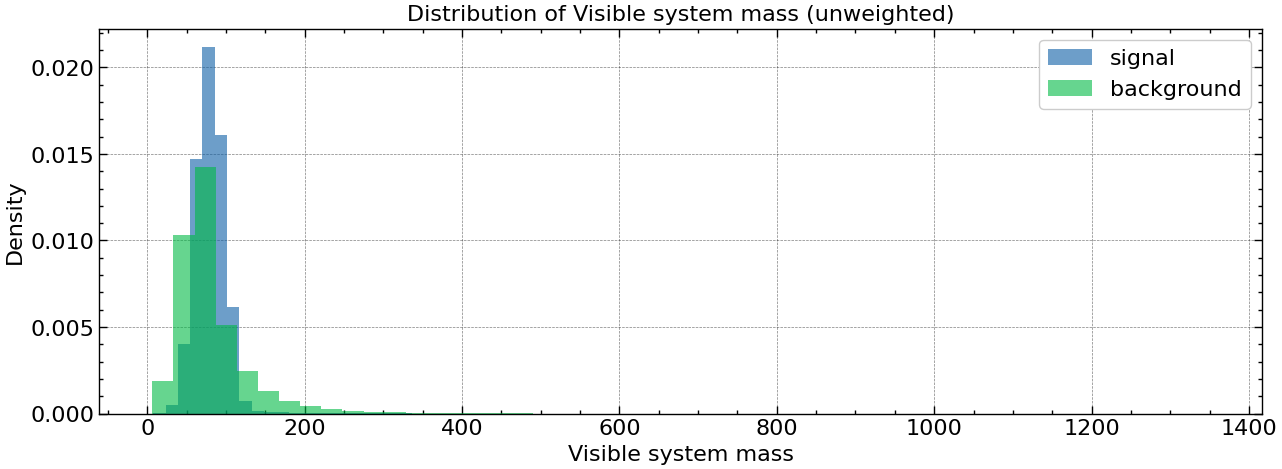

In [10]:
plt.figure(figsize=(15,5))

plt.hist(
    data[data["Label"]=="s"]["DER_mass_vis"],
    bins=50,
    alpha=0.6,
    label="signal",
    density=True
)

plt.hist(
    data[data["Label"]=="b"]["DER_mass_vis"],
    bins=50,
    alpha=0.6,
    label="background",
    density=True
)

plt.xlabel("Visible system mass")
plt.ylabel("Density")
plt.legend()
plt.title("Distribution of Visible system mass (unweighted)")
plt.show()


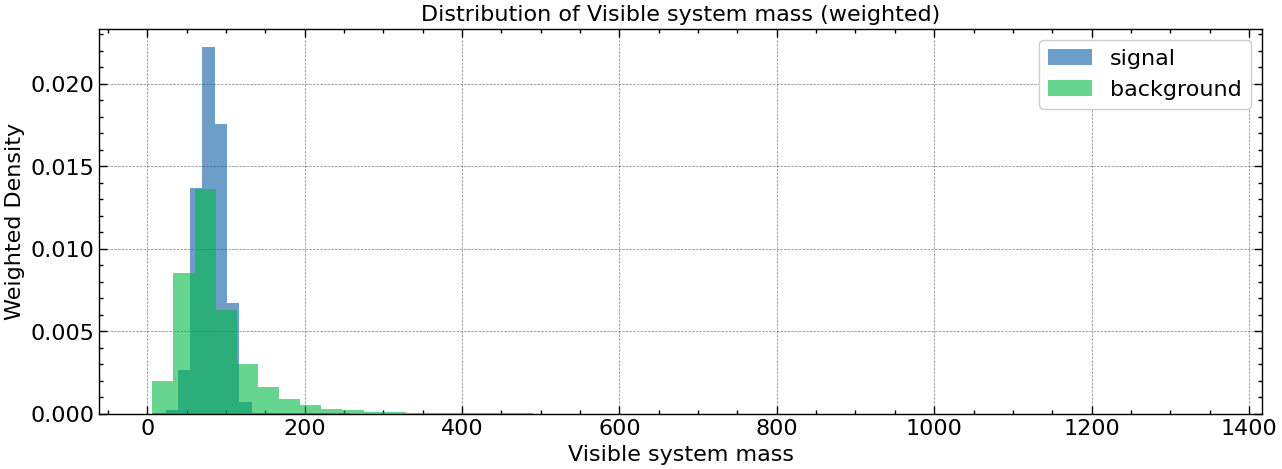

In [11]:
plt.figure(figsize=(15,5))


plt.hist(
    data[data["Label"]=="s"]["DER_mass_vis"],
    bins=50,
    weights=data[data["Label"]=="s"]["Weight"],
    alpha=0.6,
    label="signal",
    density=True
)

plt.hist(
    data[data["Label"]=="b"]["DER_mass_vis"],
    bins=50,
    weights=data[data["Label"]=="b"]["Weight"],
    alpha=0.6,
    label="background",
    density=True
)

plt.xlabel("Visible system mass")
plt.ylabel("Weighted Density")
plt.legend()
plt.title("Distribution of Visible system mass (weighted)")
plt.show()


**The visible mass alone does not provide strong separation power, but it exhibits shape differences that can contribute to multivariate classification, particularly when physical event weights are taken into account.**

**Unweighted distributions illustrate the geometric overlap between signal and background, while weighted distributions reflect the true physical importance of each class. Although individual features show limited separation power, they provide complementary information for multivariate classification.**